## **IMAGE RECOGNITION**
for Nutrimate, project capstone to complete bangkit academy batch 4
<br> C23-PS313

# **Connect to Drive**

In [1]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')


Mounted at /content/drive/


# **Preprocessing Data**

# **Import Library**

In [2]:
import os
import shutil
import stat
import seaborn as sns
import collections
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.image as img
import random
import cv2
import PIL
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
from os import listdir
from os.path import isfile, join
from collections import defaultdict
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from skimage.io import imread
from os import listdir
from os.path import join
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

%matplotlib inline

## **Detail Item**

Codes will generates a dictionary and maps food Classes to class numbers. Dictionary will be sorted by class, and the resultt will be print.

In [3]:
ClassN = {}
NClass = {}
with open('/content/drive/MyDrive/pstone/food-101/meta/classes.txt', 'r') as txt:
    classes = [i.strip() for i in txt.readlines()]
    ClassN = dict(zip(classes, range(len(classes))))
    NClass = dict(zip(range(len(classes)), classes))
    ClassN = {i: j for j, i in NClass.items()}
SortedClassN = collections.OrderedDict(sorted(ClassN.items()))
print(ClassN)


{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4}


## **Function for Generate Directory**

Function will generate a mapping between directories and the files. Function will breaks each line to get the directory name and id. The result is list in DirectoryFiles

In [4]:
# Method to generate directory-file map.
def GenerateDirectoryFIles(path):
    DirectoryFiles = defaultdict(list)
    with open(path, 'r') as txt:
        files = [i.strip() for i in txt.readlines()]
        for f in files:
            dir_name, id = f.split('/')
            DirectoryFiles[dir_name].append(id + '.jpg')
    return DirectoryFiles

## **Function for Copy Directory**
Function will checks if the target directory already exists, if not it will be copy.

In [5]:
# Method to recursively copy a directory.
def copytree(source, target, symlinks = False, ignore = None):
  if not os.path.exists(target):
      os.makedirs(target)
      shutil.copystat(source, target)
  data = os.listdir(source)
  if ignore:
      exclude = ignore(source, data)
      data = [x for x in data if x not in exclude]
  for item in data:
      src = os.path.join(source, item)
      dest = os.path.join(target, item)
      if symlinks and os.path.islink(src):
          if os.path.lexists(dest):
              os.remove(dest)
          os.symlink(os.readlink(src), dest)
          try:
              st = os.lstat(src)
              mode = stat.S_IMODE(st.st_mode)
              os.lchmod(dest, mode)
          except:
              pass
      elif os.path.isdir(src):
          copytree(src, dest, symlinks, ignore)
      else:
          shutil.copy2(src, dest)

## **Fuction for Identify File ignored**
This function will use function GenerateDirectoryFIles, it will identify file wo ignored. Function IgnoreTrain will identify for train and Function ignore_test will identify for test

In [6]:
# Train files to ignore.
def IgnoreTrain(d, filenames):
  subdir = d.split('/')[-1]
  TrainDirectoryFiles = GenerateDirectoryFIles('/content/drive/MyDrive/pstone/food-101/meta/train.txt')
  IgnoreFile = TrainDirectoryFiles[subdir]
  return IgnoreFile

# Test files to ignore.
def ignore_test(d, filenames):
  subdir = d.split('/')[-1]
  TestDirectoryFiles = GenerateDirectoryFIles('/content/drive/MyDrive/pstone/food-101/meta/test.txt')
  IgnoreFile = TestDirectoryFiles[subdir]
  return IgnoreFile

## **Function for Preprocessing Images**
Function is used to load and process images from the directory. If the image have an error it will count as invalid error, so proggrammer can antitipation of that images

In [7]:
def load_images(path_to_imgs):
    ResizeCount = 0
    InvalidCount = 0
    AllImages = []
    AllClasses = []
    InvalidImages = []  # List to store the names of invalid images

    for i, subdir in enumerate(listdir(path_to_imgs)):
        imgs = listdir(join(path_to_imgs, subdir))
        classN = ClassN[subdir]
        for img_name in imgs:
            img_path = join(path_to_imgs, subdir, img_name)
            if os.path.isfile(img_path):
                img_arr = cv2.imread(img_path)
                if img_arr is not None:
                    img_arr_rs = cv2.resize(img_arr, (200, 200), interpolation=cv2.INTER_AREA)
                    ResizeCount += 1
                    im_rgb = cv2.cvtColor(img_arr_rs, cv2.COLOR_BGR2RGB)
                    AllImages.append(im_rgb)
                    AllClasses.append(classN)
                else:
                    InvalidCount += 1
                    InvalidImages.append(img_name)  # Store the name of the invalid image
            else:
                InvalidCount += 1
                InvalidImages.append(img_name)  # Store the name of the invalid image

    print(f"Resized images: {ResizeCount}")
    print(f"Invalid images: {InvalidCount}")
    print("Invalid image names:", InvalidImages)  # Print the names of the invalid images

    return np.array(AllImages), np.array(AllClasses)

## **Function for generate Train and Test Folder**
This function will genererate folder and copy image of train or test file in target path

In [8]:
def GenerateTrainTest(path_to_imgs = '/content/drive/MyDrive/pstone/food-101/images' , target_path = '/content/drive/MyDrive/pstone/food-101'):
  copytree(path_to_imgs, target_path + '/train', ignore=ignore_test)
  copytree(path_to_imgs, target_path + '/test', ignore=IgnoreTrain)

Funtion to Load Train and Test File
This function will load the train and test file in the folder path

In [9]:
def LoadTrainTest(path_to_train_imgs, path_to_test_imgs):
  X_train, y_train = load_images(path_to_train_imgs)
  X_test, y_test = load_images(path_to_test_imgs)
  return X_train, y_train, X_test, y_test

## **Function for Run Generate Train and Test File and Count It**

Function to check if path is available or not, if the path is available it will run else and count total of train and test file. If not, it just count train and test file

In [10]:
# Generate train-test files.
if not os.path.isdir('/content/drive/MyDrive/pstone/food-101/test') and not os.path.isdir('/content/drive/MyDrive/pstone/food-101/train'):
    GenerateTrainTest()
    LenTrain = len(os.listdir('/content/drive/MyDrive/pstone/food-101/train'))
    LenTest = len(os.listdir('/content/drive/MyDrive/pstone/food-101/test'))
    print(LenTrain,LenTest)
else:
    print('train and test folders already exists.')
    LenTrain = len(os.listdir('/content/drive/MyDrive/pstone/food-101/train'))
    LenTest = len(os.listdir('/content/drive/MyDrive/pstone/food-101/test'))
    print(LenTrain,LenTest)

train and test folders already exists.
5 5


## **Sorted Food Name**

This code is to sorted the file in the path according of alphabeth

In [11]:
# List of all the food classes.
foods_sorted = sorted(os.listdir('/content/drive/MyDrive/pstone/food-101/images'))
foods_sorted

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

## **Display One of Images in Train/Test File**

This code is to check if function before is error or not. If the code is error, the images can't display. If not error, the images will display.

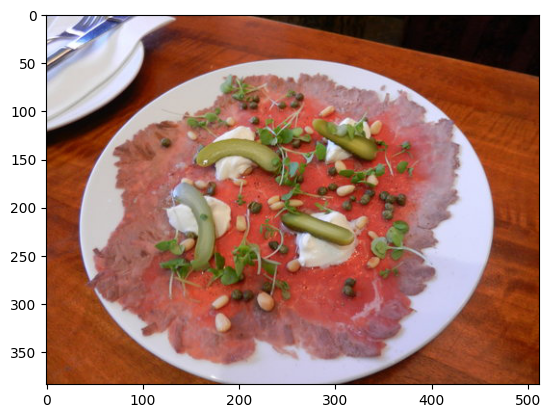

In [12]:
# Display an image.
Images = imread('/content/drive/MyDrive/pstone/food-101/train/beef_carpaccio/1011469.jpg')
plt.imshow(Images)

## **Load and Split Training and Test**

In [14]:
X_train, y_train, X_test, y_test = LoadTrainTest('/content/drive/MyDrive/pstone/food-101/train','/content/drive/MyDrive/pstone/food-101/test')

Resized images: 7502
Invalid images: 0
Invalid image names: []
Resized images: 4154
Invalid images: 0
Invalid image names: []


## **Training Model**

The code is training model with epoch = 5 and batch_size =32. It use train_samplles = 7502 and test_samples = 4154.

In [15]:
K.clear_session()

NClasses = 5
batch_size = 32
width, height = 200, 200
train_data = '/content/drive/MyDrive/pstone/food-101/train'
test_data = '/content/drive/MyDrive/pstone/food-101/test'
train_samples = 7502
test_samples = 4154

train_data_gen = ImageDataGenerator(rescale=1. / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_data_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = train_data_gen.flow_from_directory(train_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

test_gen = test_data_gen.flow_from_directory(test_data, target_size=(height, width), batch_size=batch_size, class_mode='categorical')

inception = InceptionV3(weights='imagenet', include_top=False)
layer = inception.output
layer = GlobalAveragePooling2D()(layer)
layer = Dense(128, activation='relu')(layer)
layer = Dropout(0.2)(layer)
predictions = Dense(NClasses, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(layer)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='best_model_101class.hdf5', save_best_only=True)
csv_logger = CSVLogger('history_101class.log')

history_101class = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=test_gen,
    validation_steps=len(test_gen),
    epochs=5,
    callbacks=[csv_logger, checkpointer],
    verbose=1
)

model.save('model_trained_101class.hdf5')


Found 7502 images belonging to 5 classes.
Found 4154 images belonging to 5 classes.
87910968/87910968 [==============================] - 1s 0us/step


<ipython-input-15-380e5df8ccda>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_101class = model.fit_generator(


Epoch 1/5
235/235 [==============================] - 3435s 15s/step - loss: 0.8736 - accuracy: 0.6921 - val_loss: 0.4122 - val_accuracy: 0.8758
Epoch 2/5
235/235 [==============================] - 3435s 15s/step - loss: 0.3865 - accuracy: 0.8832 - val_loss: 0.1814 - val_accuracy: 0.9629
Epoch 3/5
235/235 [==============================] - 3384s 14s/step - loss: 0.2560 - accuracy: 0.9307 - val_loss: 0.1463 - val_accuracy: 0.9692
Epoch 4/5
235/235 [==============================] - 3412s 15s/step - loss: 0.1881 - accuracy: 0.9508 - val_loss: 0.1057 - val_accuracy: 0.9848
Epoch 5/5
235/235 [==============================] - 3362s 14s/step - loss: 0.1476 - accuracy: 0.9676 - val_loss: 0.0856 - val_accuracy: 0.9863


## **Plot Accuracy**

The code is show the accuracy and val_accuracy chart

<ipython-input-16-23a1a6261d3f>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


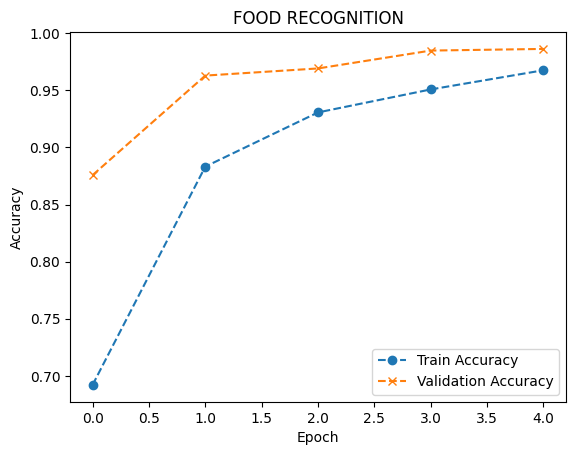

In [16]:
# Plot training-accuracy & validation-accuracy.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD RECOGNITION')
_ = plt.plot(history_101class.history['accuracy'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_accuracy'], marker='x', linestyle='dashed')
_ = plt.ylabel('Accuracy')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

## **Plot Loss**
The code is show loss and val_loss chart

<ipython-input-17-f2e7eb6f1225>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  _ = plt.style.library['seaborn-darkgrid']


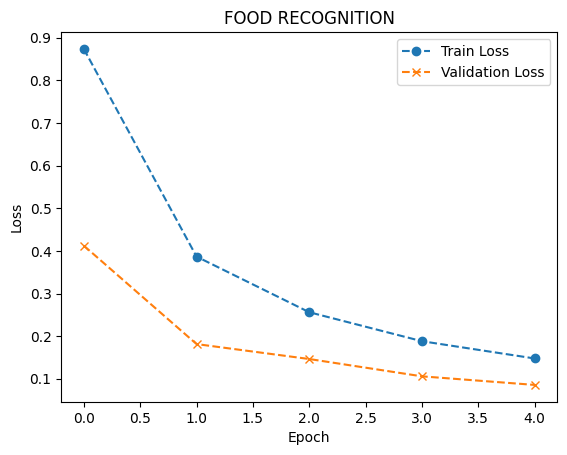

In [17]:
# Plot training-loss & validation-loss.
_ = plt.style.library['seaborn-darkgrid']
_ = plt.title('FOOD RECOGNITION')
_ = plt.plot(history_101class.history['loss'], marker='o', linestyle='dashed')
_ = plt.plot(history_101class.history['val_loss'], marker='x', linestyle='dashed')
_ = plt.ylabel('Loss')
_ = plt.xlabel('Epoch')
_ = plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

## **Load Model**

In [18]:
# Loading the best saved model to make predictions.
tensorflow.keras.backend.clear_session()
model_best = load_model('best_model_101class.hdf5',compile = False)

## **Predic Images**

In [19]:
csv_path = '/content/drive/MyDrive/pstone/calorie bangkit.csv'
dataset = pd.read_csv(csv_path)


Version 1
Function will show images and data of images

1/1 [==============================] - 2s 2s/step


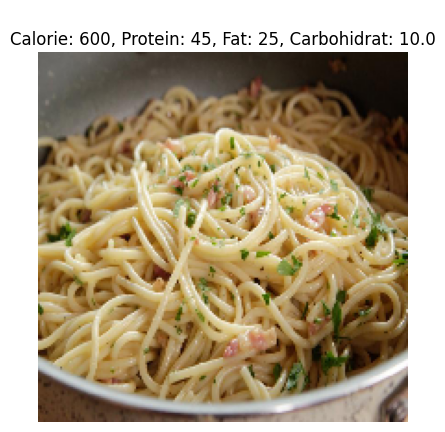

In [20]:
def predict_class(model, images, show=True):

    for img in images:
        img = image.load_img(img, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        pred_value = foods_sorted[index]

        # Retrieve additional information from the dataset based on the predicted food
        food_info = dataset[dataset['Food_Name'] == pred_value]
        calorie = food_info['Calorie'].values[0]
        protein = food_info['Protein'].values[0]
        fat = food_info['Fat'].values[0]
        carbohydrate = food_info['Carbohidrat'].values[0]

        if show:
            plt.imshow(img[0])
            plt.axis('off')
            plt.title(f"\nCalorie: {calorie}, Protein: {protein}, Fat: {fat}, Carbohidrat: {carbohydrate}")
            plt.show()
images = ['/content/drive/MyDrive/pstone/speghetticarbonara.jpg']
predict_class(model_best, images, True)

Version 2 Function just prediction data of images

In [21]:
def predict_class(model, images):
    results = []

    for img_path in images:
        img = image.load_img(img_path, target_size=(200, 200))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = img / 255.

        pred = model.predict(img)
        index = np.argmax(pred)
        pred_value = foods_sorted[index]

        # Retrieve additional information from the dataset based on the predicted food
        food_info = dataset[dataset['Food_Name'] == pred_value]
        calorie = food_info['Calorie'].values[0]
        protein = food_info['Protein'].values[0]
        fat = food_info['Fat'].values[0]
        carbohydrate = food_info['Carbohidrat'].values[0]

        result = f"Calorie: {calorie}, Protein: {protein}, Fat: {fat}, Carbohidrat: {carbohydrate}"
        results.append(result)

    return results[0]
images = ['/content/drive/MyDrive/pstone/speghetticarbonara.jpg']
predict_class(model_best, images)

1/1 [==============================] - 0s 146ms/step


'Calorie: 600, Protein: 45, Fat: 25, Carbohidrat: 10.0'